In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Objetivo: Predecir la probabilidad de que un asegurado decida no renovar su póliza (churn) en el próximo período de renovación, o anular la misma

Contexto Comercial

Soy un broker de seguros que busca minimizar la pérdida de asegurados y aumentar la retención. Quiero identificar que asegurados actuales tienen mayor probabilidad de no renovar sus pólizas en el próximo período, o anular la misma para tomar acciones proactivas y evitar el churn.

Problema Comercial

Para tomar decisiones efectivas sobre cómo abordar a los asegurados que están en riesgo de churn, es necesario contar con una probabilidad estimada de que un cliente no renueve su póliza en función de su comportamiento histórico y otros factores relevantes.

Contexto Analítico
Para desarrollar el modelo de predicción de churn, se cuenta con la siguiente información:

Agenda Clientes: Detalles de los clientes, como nombre, CUIT, DNI, contactos, tipo de seguros contratados (ramos), etc.
Cobros Unificado: Registros de los pagos realizados por los clientes, incluyendo fechas, montos y tipos de pago.
Pólizas con ID: Información sobre las pólizas de seguro, incluyendo número de póliza, tipo de seguro, fechas de inicio y fin, y estado de renovación.
Siniestros: Detalles de los siniestros reportados por los clientes, con información sobre el tipo de siniestro, estado, y fechas de ocurrencia.

In [3]:
# Levanto la data descargada
df = pd.read_excel('cobros_unificado 01-09-23 a 30-08-24.xlsx', sheet_name='FP COBROS')

Verifico y exploro los archivos descargados

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fec. Ing.             30000 non-null  object 
 1   Ingreso               30000 non-null  int64  
 2   Fec. Cobro            30000 non-null  object 
 3   Asegurado             30000 non-null  object 
 4   Cuota n°              30000 non-null  object 
 5   Póliza                30000 non-null  object 
 6   Compañía              30000 non-null  object 
 7   Mon.                  30000 non-null  object 
 8   Mto. Pagado           30000 non-null  float64
 9   Origen                30000 non-null  object 
 10  Cobrador              30000 non-null  int64  
 11  Numero De Referencia  29148 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 2.7+ MB
None


Punto de Observación: 30/06/2024


Ventana de Performance: 01/07/2024 a 30/08/2024

Calculo el Target: 

Si un asegurado tiene cobros en la ventana de performance, el target es 0 (no churn).
Si no hay cobros en ese período, el target es 1 (churn).



In [25]:
df_cobros = pd.read_excel('cobros_unificado 01-09-23 a 30-08-24.xlsx')

In [26]:
df = pd.DataFrame(df_cobros[['Fec. Cobro', 'Mto. Pagado', 'Asegurado', 'Póliza', 'Origen']])


In [29]:
print(df.head())

   Fec. Cobro  Mto. Pagado                   Asegurado        Póliza  \
0  14/06/2024   657,883.95           INTELEKTRON S.A.   4/30706114/0   
1  16/02/2024   657,883.00           INTELEKTRON S.A.   4/30706114/0   
2  15/07/2024   491,457.04  OBRA SOCIAL DE RELOJEROS    4/32425709/0   
3  11/04/2024   464,875.00     BASILE NAHUEL JEREMIAS   4/31373490/0   
4  20/05/2024   464,875.00     BASILE NAHUEL JEREMIAS   4/31373490/0   

              Origen  
0        DEB AUT CBU  
1        DEB AUT CBU  
2         PAGOS LINK  
3  PAGO FACIL ONLINE  
4  PAGO FACIL ONLINE  


In [48]:
print(df.describe())

                       Fec. Cobro  Mto. Pagado
count                       30000    30,000.00
mean   2024-02-25 15:36:20.160000    13,436.24
min           2023-08-25 00:00:00         1.69
25%           2023-11-30 00:00:00       300.00
50%           2024-02-27 00:00:00       750.00
75%           2024-05-31 00:00:00    18,645.00
max           2024-08-30 00:00:00   657,883.95
std                           NaN    26,159.87


In [30]:
print('Cantidad de nulos:')
print(df.isnull().sum())

Cantidad de nulos:
Fec. Cobro     0
Mto. Pagado    0
Asegurado      0
Póliza         0
Origen         0
dtype: int64


In [31]:
from sklearn.impute import SimpleImputer
import numpy as np 

In [32]:
import pandas as pd

# Configurar pandas para mostrar números con coma flotante y dos decimales
pd.set_option('display.float_format', '{:,.2f}'.format)

cobros_por_origen = df.groupby('Origen')['Mto. Pagado'].sum()

print(cobros_por_origen)

Origen
CAJA SELF PRODUCTORES             53,409,074.86
CAJA WEB ASEGURADOS                6,127,114.67
COBRO EXPRESS ONLINE                 641,461.75
COBRO EXPRESS PRODUCTOR ONLINE    16,259,057.55
DEB AUT AMEX                       2,431,472.26
DEB AUT CABAL                        435,797.35
DEB AUT CBU                       22,171,931.60
DEB AUT MASTERCARD                 5,241,780.31
DEB AUT NARANJA                      378,535.93
DEB AUT VISA                     120,178,693.17
DTO 1RA CTA PRODUCTOS ESPEC.          95,168.66
MULTIPAGO OFF LINE                    37,054.00
MULTIPAGO ONLINE                      37,054.00
PAGO FACIL OFFLINE (AJUSTE)          385,901.60
PAGO FACIL ONLINE                132,329,639.88
PAGO24 ONLINE                        198,750.00
PAGOMISCUENTAS ONLINE              6,154,928.59
PAGOS LINK                        13,726,427.89
PLUSPAGOS ONLINE                     650,777.89
PROVINCIA NET ONLINE               1,889,605.93
RAPIPAGO OFF LINE                

In [33]:
print(df[['Mto. Pagado']].sum())

Mto. Pagado   403,087,216.12
dtype: float64


In [34]:
print(df[['Mto. Pagado']].median())

Mto. Pagado   750.00
dtype: float64


In [35]:
print(df.groupby('Mto. Pagado').size())

Mto. Pagado
1.69            1
10.23           1
20.72          15
25.56           1
26.00         145
             ... 
464,874.28      1
464,875.00      3
491,457.04      1
657,883.00      1
657,883.95      1
Length: 7485, dtype: int64


In [37]:

import pandas as pd

# Asegúrate de que la columna 'Fec. Cobro' esté en formato de fecha
df['Fec. Cobro'] = pd.to_datetime(df['Fec. Cobro'], errors='coerce')  # Convertir a datetime y manejar errores

# Definir el rango de fechas
fecha_inicio = '2024-08-01'  # Fecha de inicio
fecha_fin = '2024-08-07'     # Fecha de fin

# Filtrar por 'Origen' que contiene 'VISA' y por rango de fechas en 'Fec. Cobro'
filtro_VISA = df[
    (df['Origen'].str.contains('VISA', case=False)) &  # Filtro por 'VISA'
    (df['Fec. Cobro'] >= fecha_inicio) &  # Filtro por fecha de inicio
    (df['Fec. Cobro'] <= fecha_fin)       # Filtro por fecha de fin
][['Asegurado', 'Fec. Cobro', 'Mto. Pagado']]  # Seleccionar solo las columnas deseadas

# Imprimir el resultado filtrado
print(filtro_VISA)

                      Asegurado Fec. Cobro  Mto. Pagado
78       ACOSTA CARLOS ALBERTO  2024-08-02   152,507.68
113          RACHELE MARIANELA  2024-08-02   135,881.00
127     ANTOLIN GASTON EDUARDO  2024-08-02   129,256.14
147      SAUCEDO LUCIA AZUCENA  2024-08-02   123,479.00
183    BONETTI EDUARDO HORACIO  2024-08-02   113,911.00
...                         ...        ...          ...
28185     PAVONI PABLO EDUARDO  2024-08-02       243.00
28186    ROMERO MARCELO RAFAEL  2024-08-02       243.00
28187     ABAT JONATHAN LEONEL  2024-08-02       243.00
28190      ROLON LUCAS GABRIEL  2024-08-05       243.00
29775     ABAT JONATHAN LEONEL  2024-08-02        46.00

[395 rows x 3 columns]


In [41]:

filtro_PAGO_FACIL = df[
    (df['Origen'].str.contains('PAGO FACIL', case=False)) &  # Filtro por 'VISA'
    (df['Fec. Cobro'] >= '2024-08-02') &  # Filtro por fecha de inicio
    (df['Fec. Cobro'] <= '2024-08-03')       # Filtro por fecha de fin
][['Asegurado', 'Fec. Cobro', 'Mto. Pagado']]  # Seleccionar solo las columnas deseadas
monto_total_PAGO_FACIL = filtro_PAGO_FACIL['Mto. Pagado'].sum()
print("Monto total de cobros con PAGO FACIL:", monto_total_PAGO_FACIL)

Monto total de cobros con PAGO FACIL: 1646830.3900000001


In [43]:
print(df.groupby('Origen')[['Mto. Pagado','Asegurado']].max())

                                Mto. Pagado                   Asegurado
Origen                                                                 
CAJA SELF PRODUCTORES            387,029.00        ZEIDAN ALFREDO DANIE
CAJA WEB ASEGURADOS              100,016.51     VAREJAO FABIAN RODOLFO 
COBRO EXPRESS ONLINE             105,955.00         SCARPECCIA MARIANO 
COBRO EXPRESS PRODUCTOR ONLINE   198,245.19  VITIELLO EMILIANO GERARDO 
DEB AUT AMEX                      91,748.00             WALFISCH DAVID 
DEB AUT CABAL                     59,930.55      IRVINI MATIAS NICOLAS 
DEB AUT CBU                      657,883.95     ZUDAIRE SERGIO GABRIEL 
DEB AUT MASTERCARD               117,072.27           VERA NORA ISABEL 
DEB AUT NARANJA                   61,856.00       ROJAS RICARDO ISMAEL 
DEB AUT VISA                     196,078.92     ZUDAIRE SERGIO GABRIEL 
DTO 1RA CTA PRODUCTOS ESPEC.      22,527.17  VAZQUEZ MAURO ERNESTO DAN 
MULTIPAGO OFF LINE                17,477.00        IMFELD NELSON

In [44]:
bins = [0,300,750,18645,float('inf')]
labels = ['Cuota baja','Cuota media','Cuota alta','Cuota muy alta']
df['Cuota_Agrupada'] = pd.cut(df['Mto. Pagado'], 
                             bins = bins, 
                             labels = labels, 
                             right = False)

In [45]:
df.head()

,Fec. Cobro,Mto. Pagado,Asegurado,Póliza,Origen,Cuota_Agrupada
0,2024-06-14,"657,883.95",INTELEKTRON S.A.,4/30706114/0,DEB AUT CBU,Cuota muy alta
1,2024-02-16,"657,883.00",INTELEKTRON S.A.,4/30706114/0,DEB AUT CBU,Cuota muy alta
2,2024-07-15,"491,457.04",OBRA SOCIAL DE RELOJEROS,4/32425709/0,PAGOS LINK,Cuota muy alta
3,2024-04-11,"464,875.00",BASILE NAHUEL JEREMIAS,4/31373490/0,PAGO FACIL ONLINE,Cuota muy alta
4,2024-05-20,"464,875.00",BASILE NAHUEL JEREMIAS,4/31373490/0,PAGO FACIL ONLINE,Cuota muy alta


In [46]:
df['Cuota_Agrupada'].value_counts()

Cuota_Agrupada
Cuota alta        11093
Cuota media        9482
Cuota muy alta     7504
Cuota baja         1921
Name: count, dtype: int64

<Axes: xlabel='Origen', ylabel='Mto. Pagado'>

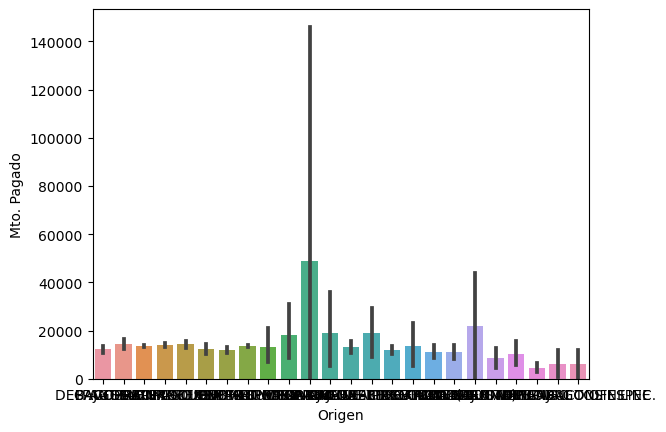

In [49]:
# Siguiendo los pasos 
# 1) Importar librerias 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 2) Crear objeto de figura
plt.figure()

# 3) Dibujar 
# BARPLOT 
sns.barplot(data = df,
           x = 'Origen',
           y = 'Mto. Pagado')

C:\Users\usuario\AppData\Local\Temp\ipykernel_6524\3756672797.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(key='Fec. Cobro', freq='M'))['Mto. Pagado'].sum().reset_index()
c:\Users\usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


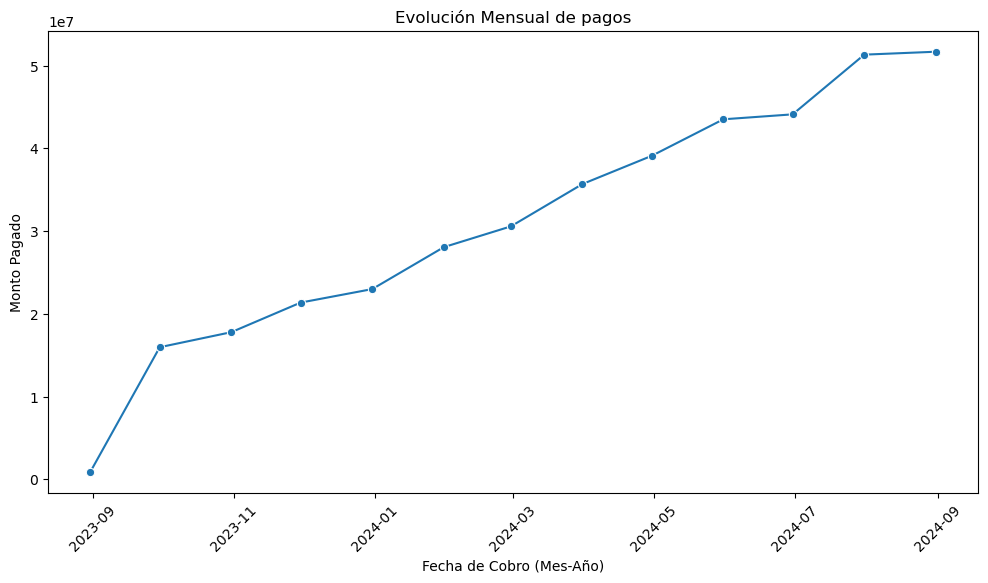

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['Fec. Cobro'] = pd.to_datetime(df['Fec. Cobro'], errors='coerce')

df_grouped = df.groupby(pd.Grouper(key='Fec. Cobro', freq='M'))['Mto. Pagado'].sum().reset_index()

df_grouped = df_grouped.sort_values(by='Fec. Cobro')

plt.figure(figsize=(12, 6))

sns.lineplot(data=df_grouped, x='Fec. Cobro', y='Mto. Pagado', marker='o')

plt.title('Evolución Mensual de pagos')
plt.xlabel('Fecha de Cobro (Mes-Año)')
plt.ylabel('Monto Pagado')
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad

# Mostrar gráfico
plt.show()

C:\Users\usuario\AppData\Local\Temp\ipykernel_6524\1640501002.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(key='Fec. Cobro', freq='M'))['Mto. Pagado'].sum().reset_index()


Text(0, 0.5, 'Monto Pagado')

<Figure size 1200x600 with 0 Axes>

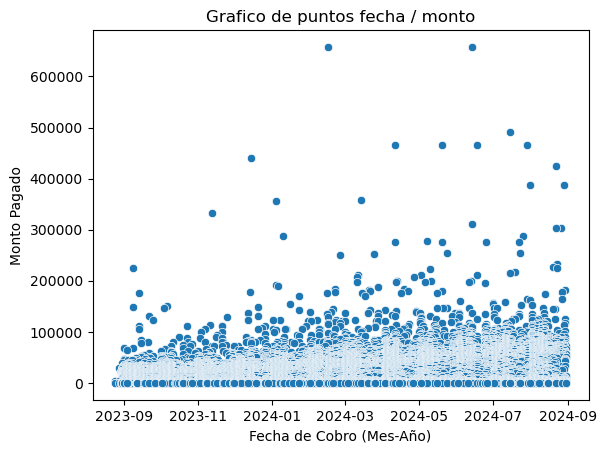

In [53]:
df['Fec. Cobro'] = pd.to_datetime(df['Fec. Cobro'], errors='coerce')

df_grouped = df.groupby(pd.Grouper(key='Fec. Cobro', freq='M'))['Mto. Pagado'].sum().reset_index()

df_grouped = df_grouped.sort_values(by='Fec. Cobro')

plt.figure(figsize=(12, 6))

plt.figure()
sns.scatterplot(data = df,
                x = 'Fec. Cobro',
                y = 'Mto. Pagado')

plt.title('Grafico de puntos fecha / monto')
plt.xlabel('Fecha de Cobro (Mes-Año)')
plt.ylabel('Monto Pagado')